In [1]:
import numpy as np
import soundfile as sf
import argparse
import os
import keras
import sklearn
import librosa
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
eps = np.finfo(np.float).eps
eps

2.220446049250313e-16

In [3]:
# load model
#import warnings
#warnings.filterwarnings("ignore")
model = keras.models.load_model(os.path.join('models', 'RNN_keras2.h5'))

E:\ProgramFiles\Anaconda3\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
# print model configuration
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 500, 60)           55680     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 40)           12960     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 500, 80)           25920     
_________________________________________________________________
maxpooling1d_1 (MaxPooling1D (None, 250, 80)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                220011    
_________________________________________________________________
activation_1 (Activation)    (None, 11)                0         
Total para

In [5]:
scaler = np.load(os.path.join("models", 'scaler.npz'))
print("scaler.keys():", scaler.keys())
print("scaler['arr_0'].shape:", scaler['arr_0'].shape)
print("scaler['arr_1'].shape:", scaler['arr_1'].shape)

scaler.keys(): ['arr_1', 'arr_0']
scaler['arr_0'].shape: (201,)
scaler['arr_1'].shape: (201,)


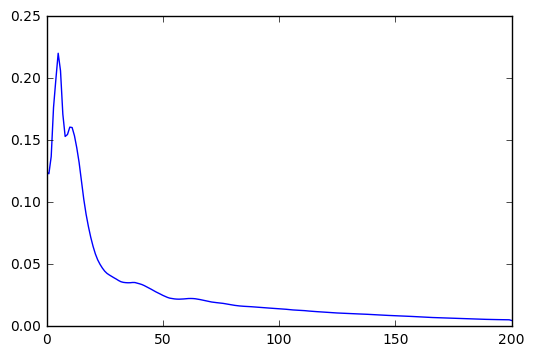

In [6]:
plt.plot(scaler['arr_0'])

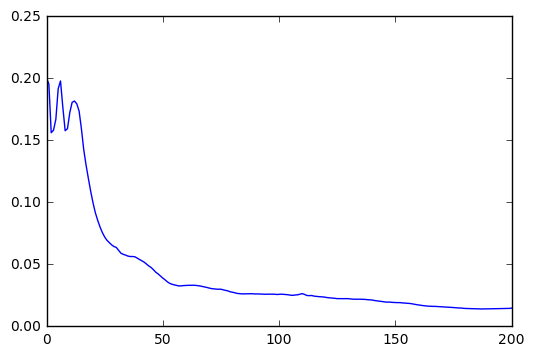

In [7]:
plt.plot(scaler['arr_1'])

In [8]:
# StandardScaler: 将每一列特征标准化为标准正太分布; 
# 计算原数据训练集的平均值和标准差，以便测试数据集使用相同的变换
scaler = sklearn.preprocessing.StandardScaler()
with np.load(os.path.join("models", 'scaler.npz')) as data: 
    scaler.mean_ = data['arr_0']
    scaler.scale_ = data['arr_1']

In [9]:
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
"""默认情况下，读取单声道文件将返回一维数组; 通过always_2d = True，即使音频文件只有一个通道，音频数据也始终以二维array的形式返回"""
audio, rate = sf.read("examples/5_speakers.wav", always_2d = True)

In [14]:
print("audio.shape:", audio.shape)
print("rate:", rate)

audio.shape: (80000, 1)
rate: 16000


In [15]:
# downmix to mono; 如果是双声道，返回的是平均值，单声道的话就是原数据
audio = np.mean(audio, axis=1)

In [19]:
# compute STFT
X = np.abs(librosa.stft(audio, n_fft=400, hop_length=160)).T
print("X.shape:", X.shape)

X.shape: (501, 201)


In [20]:
X  # STFT短时傅里叶变换

array([[3.4155674 , 1.0919566 , 2.0732613 , ..., 0.060234  , 0.06115313,
        0.01823346],
       [3.2764492 , 2.4082453 , 0.74477977, ..., 0.0918031 , 0.11035613,
        0.11769935],
       [1.7132052 , 0.83704525, 1.0020405 , ..., 0.02993787, 0.0271177 ,
        0.0567355 ],
       ...,
       [0.7392904 , 0.56522936, 2.4636614 , ..., 0.03623526, 0.03474656,
        0.07591407],
       [0.07465624, 0.44215938, 2.598801  , ..., 0.3462143 , 0.13983934,
        0.06623217],
       [1.3865798 , 1.689534  , 3.7347288 , ..., 0.35999486, 0.27668327,
        0.1288655 ]], dtype=float32)

In [21]:
# Apply standardization
X = scaler.transform(X)

In [22]:
# Cut to input shape length (500 frames x 201 STFT bins)
print(model.input_shape[1])
X = X[:model.input_shape[1], :]

500


In [23]:
print("X.shape:", X.shape)

X.shape: (500, 201)


In [28]:
# test, useless
X1 = np.array([[3,4],[0.3,0.4],[30,40]])
Theta1 = np.linalg.norm(X1, axis=1)
X1 /= np.mean(Theta1)
print("Theta1:\n", Theta1)
print("X1:\n", X1)

Theta1:
 [ 5.   0.5 50. ]
X1:
 [[0.16216216 0.21621622]
 [0.01621622 0.02162162]
 [1.62162162 2.16216216]]


In [25]:
# Apply normalization归一化; 二范数:平方和后求算术平方根; axis=1:按行向量处理
Theta = np.linalg.norm(X, axis=1) + eps
print("Theta.shape:", Theta.shape)
X /= np.mean(Theta)
print("X.shape:", X.shape)

Theta.shape: (500,)
X.shape: (500, 201)


In [30]:
# Add sample dimension, 表示只有一个样本
Xs = X[np.newaxis, ...]
print("Xs.shape:", Xs.shape)

Xs.shape: (1, 500, 201)


In [32]:
# predict output
ys = model.predict(Xs, verbose=0)
print("ys:\n", ys)
predict_num = np.argmax(ys, axis=1)
print("predict_num:", predict_num)
print("Speaker Count Estimate: ", predict_num[0])

ys:
 [[1.4688802e-10 1.3538984e-17 4.1643564e-09 2.1747644e-04 7.2500065e-02
  7.2199446e-01 1.9145003e-01 1.3670632e-02 1.6597265e-04 1.4802429e-06
  1.4091490e-08]]
predict_num: [5]
Speaker Count Estimate:  5


### Model Summary: 
Layer |  Layer Name | Input Shape | Output Shape 
:-: | :-: | :-: | :-: 
the First Layer  | BLSTM_1 | (?, 500, 201) | (?, 500, 60) 
the Second Layer | BLSTM_2 | (?, 500, 60)  | (?, 500, 40) 
the Third Layer  | BLSTM_3 | (?, 500, 40)  | (?, 500, 80)
the Fourth Layer | maxpooling1d | (?, 500, 80) | (?, 250, 80) 
the Fifth Layer | flatten | (?, 250, 80) | (?, 20000) 
the Sixth Layer | dense | (?, 20000) | (?, 11) 
the Seventh Layer | activation | (?, 11) | (?, 11) 

"?" represents the number of samples.<br> 

In [43]:
# 打印模型配置信息
model.get_config()

[{'class_name': 'Bidirectional',
  'config': {'batch_input_shape': (None, 500, 201),
   'dtype': 'float32',
   'layer': {'class_name': 'LSTM',
    'config': {'activation': 'tanh',
     'activity_regularizer': None,
     'batch_input_shape': (None, None, None),
     'bias_constraint': None,
     'bias_initializer': {'class_name': 'Zeros', 'config': {}},
     'bias_regularizer': None,
     'dropout': 0.0,
     'dtype': 'float32',
     'go_backwards': False,
     'implementation': 2,
     'kernel_constraint': None,
     'kernel_initializer': {'class_name': 'VarianceScaling',
      'config': {'distribution': 'uniform',
       'mode': 'fan_avg',
       'scale': 1.0,
       'seed': None}},
     'kernel_regularizer': None,
     'name': 'lstm_1',
     'recurrent_activation': 'hard_sigmoid',
     'recurrent_constraint': None,
     'recurrent_dropout': 0.0,
     'recurrent_initializer': {'class_name': 'Orthogonal',
      'config': {'gain': 1.0, 'seed': None}},
     'recurrent_regularizer': None,